# Adaptive Density Estimation By Bayesian Averaging (ADEBA)

In [1]:
from sklearn.decomposition import PCA
import numpy as np
from matplotlib import pyplot as plt
import math
from sklearn.neighbors import KernelDensity

## Creating a toy Data

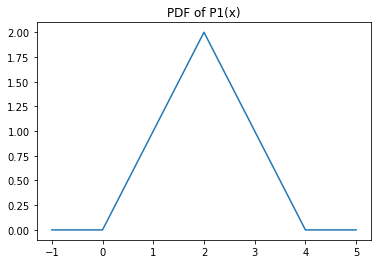

In [2]:
def f1(x):
    if(x>=0 and x<2):
        return x
    elif(x>=2 and x<4):
        return 4-x
    else:
        return 0

x = np.arange(-1, 6)
f1_dist = np.vectorize(f1)
p1 = f1_dist(x)
plt.plot(x, p1)
plt.title('PDF of P1(x)')
plt.show()

In [3]:
def sample_generator(pdf , N , a, b):
    sample = np.linspace(a, b, N)
    prob = []
    normalizer = 0
    for x in sample:
        p = pdf(x)
        normalizer += p
        prob.append(p)
    prob = prob / normalizer
    return np.random.choice(sample, p=prob, size=N)

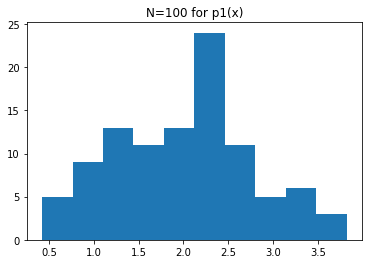

In [4]:
f1_sample = sample_generator(f1, 100, 0, 6)
plt.hist(f1_sample)
plt.title('N=100 for p1(x)')
plt.show()

In [ ]:
mean = [1, 1, 0]
cov = [[4, 1, -1], [1,2,1], [-1, 1, 2]]
f2_sample = np.random.multivariate_normal(mean, cov, 10000)

## Data preprocessing

In [ ]:
def preprocess(X):
    pca = PCA(whiten=True)
    whitened = pca.fit_transform(X)
    return whitened

In [ ]:
p = preprocess(np.array(f1_sample).reshape(-1,1))
np.cov(p.flatten())

array(1.)

In [ ]:
p = preprocess(np.array(f2_sample))
np.round(np.cov(p, rowvar=False))

array([[ 1.,  0.,  0.],
       [ 0.,  1., -0.],
       [ 0., -0.,  1.]])

## defining ADEBA

In [ ]:
class ADEBA:
    def __init__(self, pilot=None, beta=None, T=1000, prior='uniform'):
        self.pilot= pilot
        self.prior = prior
        self.beta = beta
        self.T = T
        self.alpha=None
        self.pca = PCA(whiten=True)
        
    def reverse(self,p):
        p = self.pca.inverse_transform(p)
        return p    
   
    def _initialize(self, X):
        whitened = self.pca.fit_transform(X)
        return whitened
    
    def EstimateDensity(self, X):
        transformed_data = self._initialize(X)
        if self.pilot == None:
          #set the pilot as uniform distribution
            self.pilot = np.ones(X.shape)
        for i in range(self.T):
            A, W = self._findintegration(transformed_data, self.beta)
            self.pilot = self._calculatePDF(transformed_data, self.beta, A, W)
        return(self.pilot)
    
    def _findintegration(self, X, B):
        A = []
        W = []
        w_sum = 0
        for beta in B:
            a_beta = self._findAlpha(X, beta) # a list of size 40*1
            a_diff = np.diff(a_beta)[0]
            w_beta = []
            for a in a_beta:
                bw = (a/(self.pilot)**beta)
                lh = self._likelihood(X, bw)
                w_beta.append(lh*a_diff)
            w_sum += np.sum(w_beta)
            A.append({'beta':beta, 'a_beta':np.array(a_beta)})
            W.append({'beta':beta, 'w_beta':np.array(w_beta)})
        for d in W:
            d['w_beta'] = d['w_beta']/w_sum
            # print("Normalized w", d['w_beta'])
        return A, W
            
    
    def _calculatePDF(self, X, B, A, W):
        p = X.shape[1]
        n = X.shape[0]
        final_pdf = np.zeros((X.shape[0], 1))
        for beta in B:
            a_beta = [i['a_beta'] for i in A if i['beta'] == beta][0]
            w_beta = [i['w_beta'] for i in W if i['beta'] == beta][0]
            # print('a beta', a_beta.shape)
            # print('w beta', w_beta.shape)
            for i in range(len(a_beta)):
                bw = a_beta[i]/(self.pilot**beta)
                # print("bandwidths", bw[0])
                dist = np.zeros((X.shape[0], 1))
                for j in range(n):
                    for k in range(n):
                        dist[j] += (1/(bw[j]**(p-1))) * (1/(np.pi**((p-1)/2))) * np.exp((-1/2)*(np.linalg.norm(X[k] - X[j])/bw[j])**2)
                    dist[j] = dist[j]/n
                final_pdf += w_beta[i] * dist
            
        return final_pdf
    
    def _findAlpha(self, X, beta):
        #default vlues of algorithm
        alpha_min = 10**(-6)
        alpha_max = 10**3
        n_alpha1 = 10
        n_alpha2 = 40
        thresh = 10**(-3)
        
        for i in range(2):
            alpha = np.logspace(np.log10(alpha_min), np.log10(alpha_max), num=n_alpha1).flatten()
            likelihood = []
            for a in alpha:
                # print(a)
                bw = (a/(self.pilot)**beta)
                likelihood.append(self._likelihood(X, bw))
            likelihood = np.array(likelihood).flatten()
            t_max = np.max(likelihood) * thresh
            # print('likelihood:', likelihood, t_max)
            idx_min = []
            idx_max = []
            for i in range(len(likelihood)):
              if likelihood[i] < t_max:
                if likelihood[(i+1)%len(likelihood)] >= t_max:
                  idx_min.append(i)
                elif likelihood[i-1] >= t_max:
                  idx_max.append(i)
            if len(idx_max) == 0:
              idx_max.append([len(likelihood)-1])
            if len(idx_min) == 0:
              idx_min.append([0]) 
            alpha_max = np.min(alpha[idx_max])
            alpha_min = np.min(alpha[idx_min])
            
        alpha = np.logspace(np.log10(alpha_min), np.log10(alpha_max), num=n_alpha2).flatten()
        # print('final alpha:', alpha.shape)
        return alpha
            
            
    def _likelihood(self, X, bw):
        # pay attention that it calaulates in leave-one-out manner
        p = X.shape[1]
        n = X.shape[0]
        likelihood = 1
        for i in range(X.shape[0]):
            dist = 0
            for j in range(X.shape[0]):
              #because we have leave-one-out
                if j != i:
                    dist += (1/(bw[j]**p)) * (1/(np.pi**(p/2))) * np.exp((-1/2)*((np.linalg.norm(X[i] - X[j])/bw[j])**2))
            if dist != 0:
                likelihood += dist/(n-1)
            
        return likelihood
    

## Testing ADEBA on toy dataset

In [ ]:
adeba = ADEBA(beta=[0, 1, 0.5], T = 5)
p = adeba.EstimateDensity(f1_sample.reshape(-1, 1))

<ipython-input-13-dbb2e43289b0>:100: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  alpha_max = np.min(alpha[idx_max])
<ipython-input-13-dbb2e43289b0>:101: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  alpha_min = np.min(alpha[idx_min])


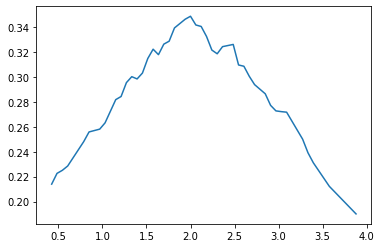

In [ ]:
q = adeba.reverse(p)
idx = np.argsort(f1_sample)
plt.plot(f1_sample[idx], p[idx])
plt.show()

## Impact of changing alpha_min and alpha_max also retransforming

In [16]:
class ADEBA_alpha:
    def __init__(self, pilot=None, beta=None, T=1000, prior='uniform'):
        self.pilot= pilot
        self.prior = prior
        self.beta = beta
        self.T = T
        self.alpha=None
        self.pca = PCA(whiten=True)
        
    def reverse(self,p):
        p = self.pca.inverse_transform(p)
        return p    
   
    def _initialize(self, X):
        whitened = self.pca.fit_transform(X)
        return whitened
    
    def EstimateDensity(self, X):
        transformed_data = self._initialize(X)
        if self.pilot == None:
          #set the pilot as uniform distribution
            self.pilot = np.ones(X.shape)
        for i in range(self.T):
            A, W = self._findintegration(transformed_data, self.beta)
            self.pilot = self._calculatePDF(transformed_data, self.beta, A, W)
        return(self.pilot)
    
    def _findintegration(self, X, B):
        A = []
        W = []
        w_sum = 0
        for beta in B:
            a_beta = self._findAlpha(X, beta) # a list of size 40*1
            a_diff = np.diff(a_beta)[0]
            w_beta = []
            for a in a_beta:
                bw = (a/(self.pilot)**beta)
                lh = self._likelihood(X, bw)
                w_beta.append(lh*a_diff)
            w_sum += np.sum(w_beta)
            A.append({'beta':beta, 'a_beta':np.array(a_beta)})
            W.append({'beta':beta, 'w_beta':np.array(w_beta)})
        for d in W:
            d['w_beta'] = d['w_beta']/w_sum
            # print("Normalized w", d['w_beta'])
        return A, W
            
    
    def _calculatePDF(self, X, B, A, W):
        p = X.shape[1]
        n = X.shape[0]
        final_pdf = np.zeros((X.shape[0], 1))
        for beta in B:
            a_beta = [i['a_beta'] for i in A if i['beta'] == beta][0]
            w_beta = [i['w_beta'] for i in W if i['beta'] == beta][0]
            # print('a beta', a_beta.shape)
            # print('w beta', w_beta.shape)
            for i in range(len(a_beta)):
                bw = a_beta[i]/(self.pilot**beta)
                # print("bandwidths", bw[0])
                dist = np.zeros((X.shape[0], 1))
                for j in range(n):
                    for k in range(n):
                        dist[j] += (1/(bw[j]**(p-1))) * (1/(np.pi**((p-1)/2))) * np.exp((-1/2)*(np.linalg.norm(X[k] - X[j])/bw[j])**2)
                    dist[j] = dist[j]/n
                final_pdf += w_beta[i] * dist
            
        return final_pdf
    
    def _findAlpha(self, X, beta):
        #default vlues of algorithm
        alpha_min = 10**(-6)
        alpha_max = 10**0
        n_alpha1 = 10
        n_alpha2 = 40
        thresh = 10**(-3)
        
        for i in range(2):
            alpha = np.logspace(np.log10(alpha_min), np.log10(alpha_max), num=n_alpha1).flatten()
            likelihood = []
            for a in alpha:
                # print(a)
                bw = (a/(self.pilot)**beta)
                likelihood.append(self._likelihood(X, bw))
            likelihood = np.array(likelihood).flatten()
            t_max = np.max(likelihood) * thresh
            # print('likelihood:', likelihood, t_max)
            idx_min = []
            idx_max = []
            for i in range(len(likelihood)):
              if likelihood[i] < t_max:
                if likelihood[(i+1)%len(likelihood)] >= t_max:
                  idx_min.append(i)
                elif likelihood[i-1] >= t_max:
                  idx_max.append(i)
            if len(idx_max) == 0:
              idx_max.append([len(likelihood)-1])
            if len(idx_min) == 0:
              idx_min.append([0]) 
            alpha_max = np.min(alpha[idx_max])
            alpha_min = np.min(alpha[idx_min])
            
        alpha = np.logspace(np.log10(alpha_min), np.log10(alpha_max), num=n_alpha2).flatten()
        # print('final alpha:', alpha.shape)
        return alpha
            
            
    def _likelihood(self, X, bw):
        # pay attention that it calaulates in leave-one-out manner
        p = X.shape[1]
        n = X.shape[0]
        likelihood = 1
        for i in range(X.shape[0]):
            dist = 0
            for j in range(X.shape[0]):
              #because we have leave-one-out
                if j != i:
                    dist += (1/(bw[j]**p)) * (1/(np.pi**(p/2))) * np.exp((-1/2)*((np.linalg.norm(X[i] - X[j])/bw[j])**2))
            if dist != 0:
                likelihood += dist/(n-1)
            
        return likelihood
    

In [12]:
## result with narrow alpha band
## alpha min = 1, alpha_max=10^3
adeba = ADEBA_alpha(beta=[0, 1, 0.5], T = 5)
p = adeba.EstimateDensity(f1_sample.reshape(-1, 1))

<ipython-input-11-fb476f44ddd7>:100: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  alpha_max = np.min(alpha[idx_max])
<ipython-input-11-fb476f44ddd7>:101: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  alpha_min = np.min(alpha[idx_min])


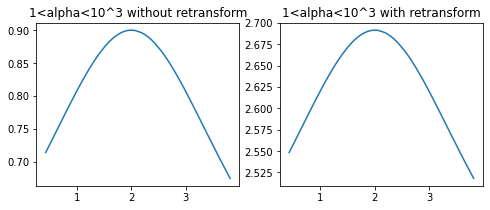

In [15]:
q = adeba.reverse(p)
fig, axs = plt.subplots(1,2, figsize = (8,3))
idx = np.argsort(f1_sample)
axs[0].plot(f1_sample[idx], p[idx])
axs[0].set_title('1<alpha<10^3 without retransform')
axs[1].plot(f1_sample[idx], q[idx])
axs[1].set_title('1<alpha<10^3 with retransform')
plt.show()

In [17]:
## result with narrow alpha band
## alpha min = 10^-6, alpha_max=10^0
adeba = ADEBA_alpha(beta=[0, 1, 0.5], T = 5)
p = adeba.EstimateDensity(f1_sample.reshape(-1, 1))

<ipython-input-16-e1febd3367cf>:100: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  alpha_max = np.min(alpha[idx_max])
<ipython-input-16-e1febd3367cf>:101: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  alpha_min = np.min(alpha[idx_min])


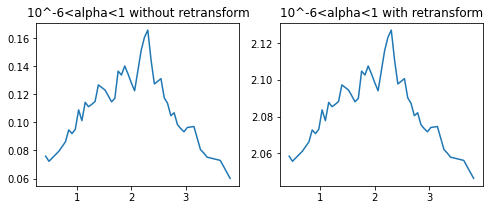

In [19]:
q = adeba.reverse(p)
fig, axs = plt.subplots(1,2, figsize = (8,3))
idx = np.argsort(f1_sample)
axs[0].plot(f1_sample[idx], p[idx])
axs[0].set_title('10^-6<alpha<1 without retransform')
axs[1].plot(f1_sample[idx], q[idx])
axs[1].set_title('10^-6<alpha<1 with retransform')
plt.show()

## creating benchmarks

In [ ]:
distributions = [
    {"Name": "Gaussian", "s": [1], "w": [1], "x": [0]},
    {"Name": "Skewed", "s": [1, 2/3, 5/9], "w": [1/5, 1/5, 3/5], "x": [0, 1/2, 13/12]},
    {"Name": "Strongly skewed", "s": [(2/3)**i for i in range(0,8)], "w": [1/8]*8, "x": [3*((2/3)**i - 1) for i in range(0,8)]},
    {"Name": "Kurtotic", "s": [1, 1/10], "w": [2/3, 1/3], "x": [0, 0]},
    {"Name": "Outliers", "s": [1, 1/10], "w": [1/10, 9/10], "x": [0, 0]},
    {"Name": "Bimodal", "s": [2/3]*2, "w": [.5, .5], "x": [-1, 1]},
    {"Name": "Separated", "s": [.5, .5], "w": [.5, .5], "x": [-1.5, 1.5]},
    {"Name": "Asm. Bimodal", "s": [1, 1/3], "w": [.75, .25], "x": [0, 1.5]},
    {"Name": "Trimodal", "s": [.6, .6, .25], "w": [9/20, 9/20, 2/20], "x": [-1.2, 1.2, 0]},
    {"Name": "Claw", "s": [1]+[0.1]*5, "w": [0.5]+[0.1]*5, "x": [0]+[(i/2)-1 for i in range(0,5)]},
    {"Name": "Double Claw", "s": [2/3, 2/3]+[0.01]*7, "w": [0.49, 0.49]+[1/350]*7, "x":[-1, 1, -1.5, -1, -0.5, 0, 0.5, 1, 1.5]},
    {"Name": "Asymmetric Claw", "s": [1]+[(2**i)/10 for i in range(2, -3, -1)], "w": [1/2]+[(2**i)/31 for i in range(3, -2, -1)], "x": [0, -1.5, -0.5, 0.5, 1.5, 2.5]},
    {"Name": "Asm. Dbl. Claw", "s": [2/3]+[2/3]+[0.01]*3+[0.07]*3, "w": [0.46, 0.46]+[1/300]*3+[7/300]*3, "x": [-1, 1, -1/2, -1, -3/2, 1/2, 1, 3/2]},
    {"Name": "Smooth Comb", "s": [(32/63)/2**i for i in range(0,6)], "w": [((2**i)/63) for i in range(5,-1,-1)], "x":[(65-(96*(0.5**i)))/21 for i in range(0,6)]},
    {"Name": "Discrete Comb", "s": [2/7]*3 + [1/21]*3, "w": [2/7]*3 + [1/21]*3, "x": [(12*i)-15 for i in range(0,3)] + [2*i/7 for i in range(8,11)]},
]

def dist_calc(x, s, w, m):
    final_dist = w[0] * np.exp(-((x - m[0])/s[0])**2 / 2) / (s[0] * np.sqrt(2 * np.pi))
    for i in range(1,len(s)):
        final_dist += w[i] * np.exp(-((x - m[i])/s[i])**2 / 2) / (s[i] * np.sqrt(2 * np.pi))
    return final_dist

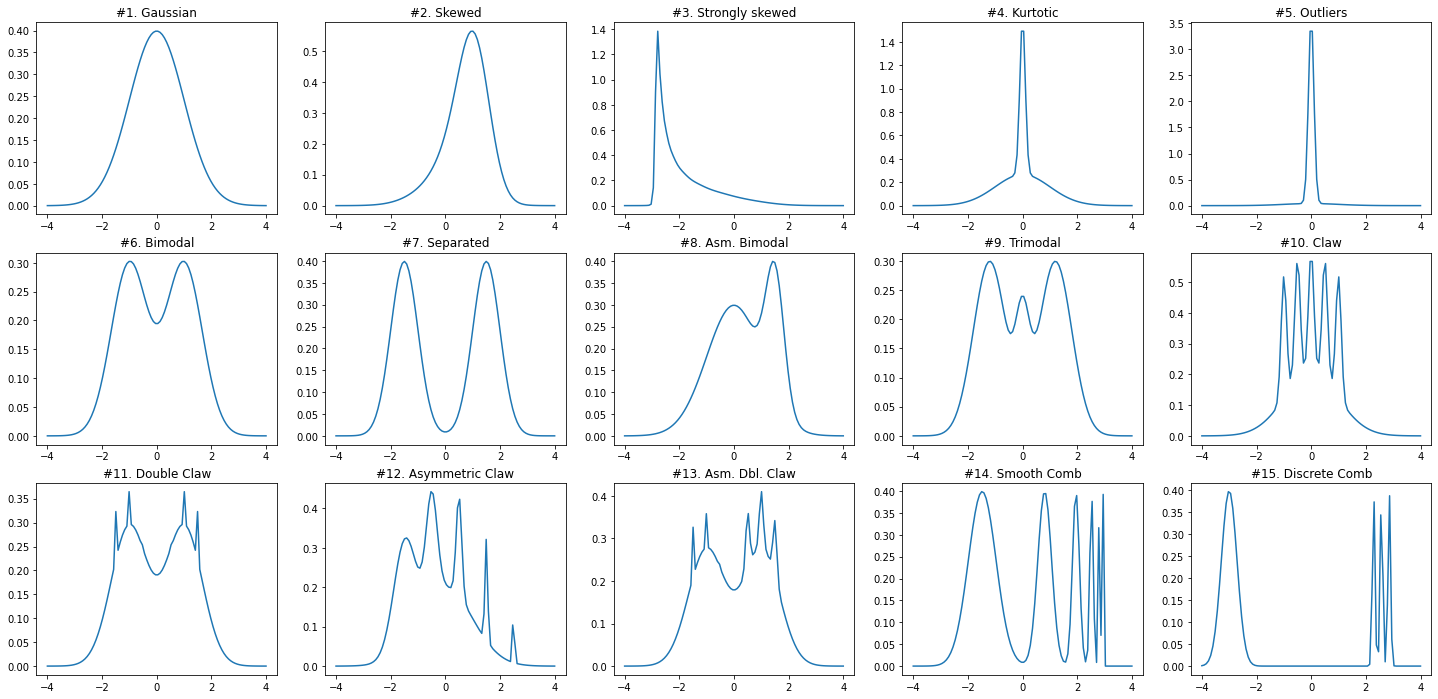

In [ ]:
fig, axs = plt.subplots(3, 5, figsize=(25, 12))
k = 0
for dist in distributions:
    x = np.linspace(-4, 4, 100)
    s = dist['s']
    w = dist['w']
    x0 = dist['x']
    y = dist_calc(x, s, w, x0)
    axs[k//5, k%5].plot(x, y)
    axs[k//5, k%5].set_title('#'+str(k+1)+'. '+dist['Name'])
    k+=1

## Testing on benchmarks

In [ ]:

def sample_distribution(sample, pdf, w, s, m, N , a, b):
    prob = []
    normalizer = 0
    for x in sample:
        p = pdf(x, s, w, m)
        normalizer += p
        prob.append(p)
    prob = prob / normalizer
    return np.random.choice(sample, p=prob, size=N)

In [ ]:
def estimate(dist):
    s = dist['s']
    w = dist['w']
    x0 = dist['x']
    x = np.linspace(-4, 4, 100)
    y = dist_calc(x, s, w, x0)
    f3_sample = sample_distribution(x, dist_calc, w, s, x0, 100, -4, 4)
    adeba = ADEBA(beta=[0, 1, 0.5], T = 3)
    p = adeba.EstimateDensity(f3_sample.reshape(-1, 1))
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].plot(x, y)
    axs[0].set_title('Main Distribution')
    axs[1].hist(f3_sample)
    axs[1].set_title('Histogram of Samples')
    idx = np.argsort(f3_sample)
    axs[2].plot(f3_sample[idx], p[idx])
    axs[2].set_title('Result of ADEBA')

Text(0.5, 1.0, 'Result of ADEBA')

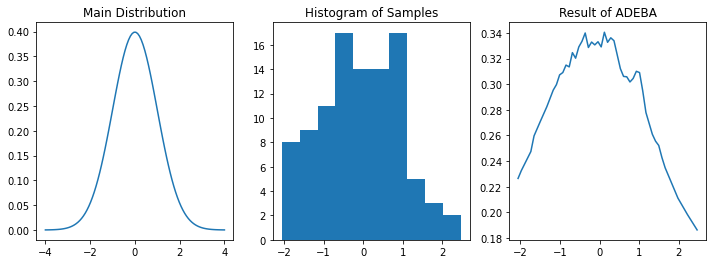

In [ ]:
k = 0
dist = distributions[k]
s = dist['s']
w = dist['w']
x0 = dist['x']
x = np.linspace(-4, 4, 100)
y = dist_calc(x, s, w, x0)
f3_sample = sample_distribution(x, dist_calc, w, s, x0, 100, -4, 4)
adeba = ADEBA(beta=[0, 1, 0.5], T = 3)
p = adeba.EstimateDensity(f3_sample.reshape(-1, 1))
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].plot(x, y)
axs[0].set_title('Main Distribution')
axs[1].hist(f3_sample)
axs[1].set_title('Histogram of Samples')
idx = np.argsort(f3_sample)
axs[2].plot(f3_sample[idx], p[idx])
axs[2].set_title('Result of ADEBA')

<ipython-input-13-dbb2e43289b0>:100: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  alpha_max = np.min(alpha[idx_max])
<ipython-input-13-dbb2e43289b0>:101: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  alpha_min = np.min(alpha[idx_min])


Text(0.5, 1.0, 'Result of ADEBA')

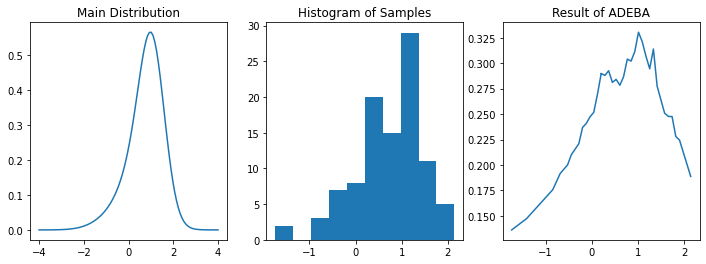

In [ ]:
k = 1
dist = distributions[k]
s = dist['s']
w = dist['w']
x0 = dist['x']
x = np.linspace(-4, 4, 100)
y = dist_calc(x, s, w, x0)
f3_sample = sample_distribution(x, dist_calc, w, s, x0, 100, -4, 4)
adeba = ADEBA(beta=[0, 1, 0.5], T = 3)
p = adeba.EstimateDensity(f3_sample.reshape(-1, 1))
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].plot(x, y)
axs[0].set_title('Main Distribution')
axs[1].hist(f3_sample)
axs[1].set_title('Histogram of Samples')
idx = np.argsort(f3_sample)
axs[2].plot(f3_sample[idx], p[idx])
axs[2].set_title('Result of ADEBA')

<ipython-input-13-dbb2e43289b0>:100: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  alpha_max = np.min(alpha[idx_max])
<ipython-input-13-dbb2e43289b0>:101: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  alpha_min = np.min(alpha[idx_min])


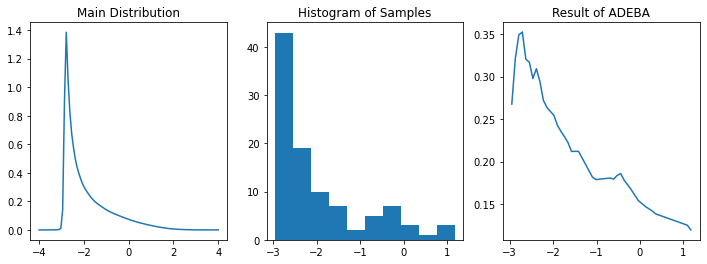

In [ ]:
k = 2
estimate(distributions[k])

<ipython-input-13-dbb2e43289b0>:100: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  alpha_max = np.min(alpha[idx_max])
<ipython-input-13-dbb2e43289b0>:101: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  alpha_min = np.min(alpha[idx_min])


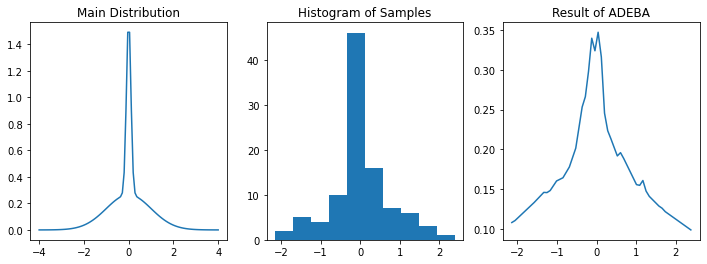

In [ ]:
k = 3
estimate(distributions[k])

<ipython-input-13-dbb2e43289b0>:100: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  alpha_max = np.min(alpha[idx_max])
<ipython-input-13-dbb2e43289b0>:101: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  alpha_min = np.min(alpha[idx_min])


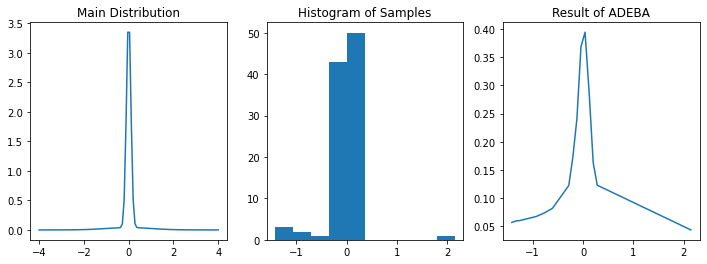

In [ ]:
k = 4
estimate(distributions[k])

<ipython-input-13-dbb2e43289b0>:100: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  alpha_max = np.min(alpha[idx_max])
<ipython-input-13-dbb2e43289b0>:101: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  alpha_min = np.min(alpha[idx_min])


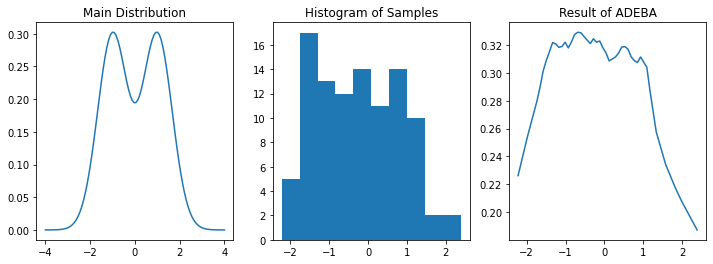

In [ ]:
k = 5
estimate(distributions[k])

<ipython-input-13-dbb2e43289b0>:100: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  alpha_max = np.min(alpha[idx_max])
<ipython-input-13-dbb2e43289b0>:101: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  alpha_min = np.min(alpha[idx_min])


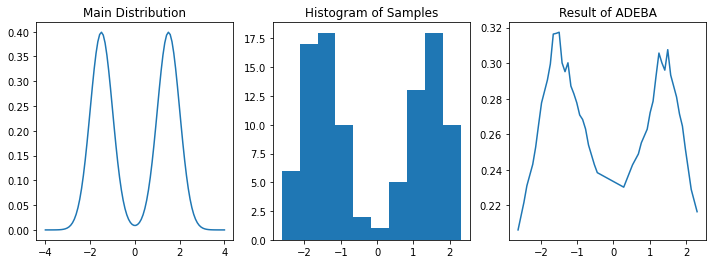

In [ ]:
k = 6
estimate(distributions[k])

<ipython-input-13-dbb2e43289b0>:100: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  alpha_max = np.min(alpha[idx_max])
<ipython-input-13-dbb2e43289b0>:101: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  alpha_min = np.min(alpha[idx_min])


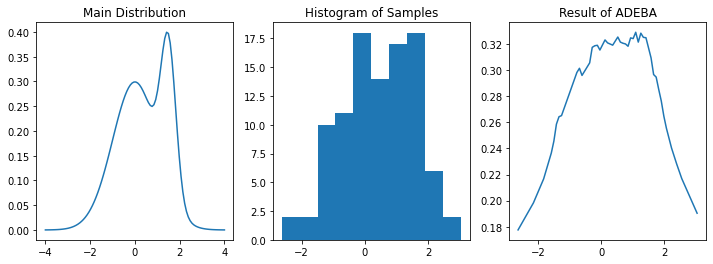

In [ ]:
k = 7
estimate(distributions[k])

<ipython-input-13-dbb2e43289b0>:100: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  alpha_max = np.min(alpha[idx_max])
<ipython-input-13-dbb2e43289b0>:101: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  alpha_min = np.min(alpha[idx_min])


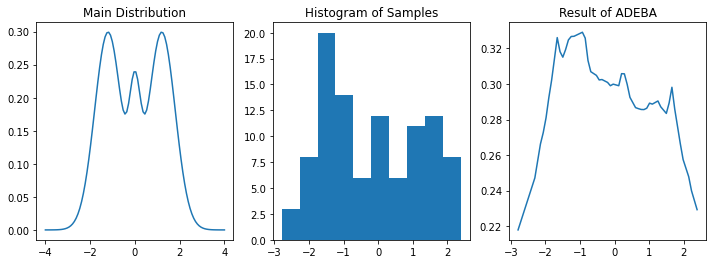

In [ ]:
k = 8
estimate(distributions[k])

<ipython-input-13-dbb2e43289b0>:100: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  alpha_max = np.min(alpha[idx_max])
<ipython-input-13-dbb2e43289b0>:101: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  alpha_min = np.min(alpha[idx_min])


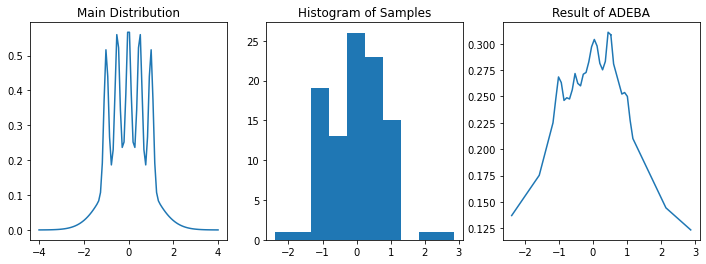

In [ ]:
k = 9
estimate(distributions[k])

<ipython-input-13-dbb2e43289b0>:100: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  alpha_max = np.min(alpha[idx_max])
<ipython-input-13-dbb2e43289b0>:101: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  alpha_min = np.min(alpha[idx_min])


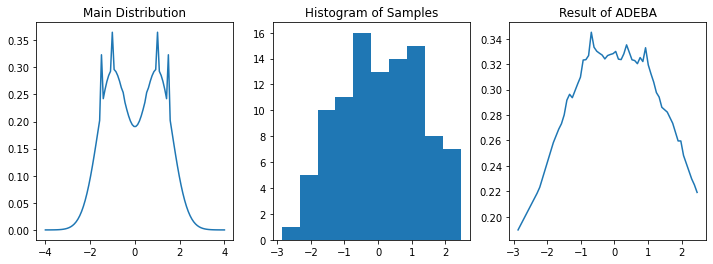

In [ ]:
k = 10
estimate(distributions[k])

<ipython-input-13-dbb2e43289b0>:100: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  alpha_max = np.min(alpha[idx_max])
<ipython-input-13-dbb2e43289b0>:101: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  alpha_min = np.min(alpha[idx_min])


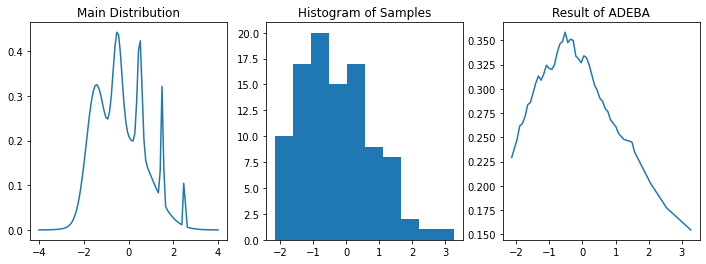

In [ ]:
k = 11
estimate(distributions[k])

<ipython-input-13-dbb2e43289b0>:100: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  alpha_max = np.min(alpha[idx_max])
<ipython-input-13-dbb2e43289b0>:101: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  alpha_min = np.min(alpha[idx_min])


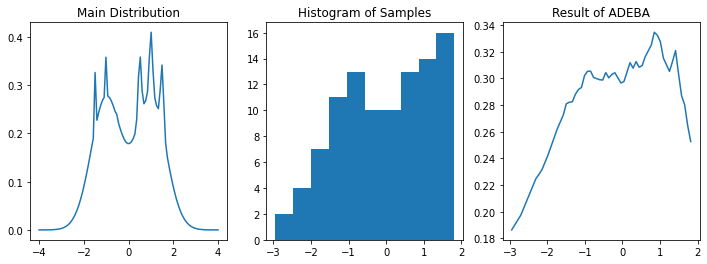

In [ ]:
k = 12
estimate(distributions[k])

<ipython-input-13-dbb2e43289b0>:100: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  alpha_max = np.min(alpha[idx_max])
<ipython-input-13-dbb2e43289b0>:101: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  alpha_min = np.min(alpha[idx_min])


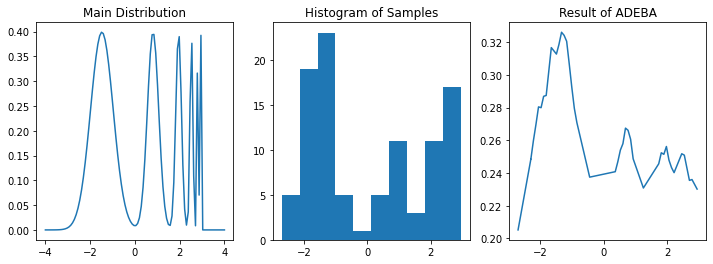

In [ ]:
k = 13
estimate(distributions[k])

<ipython-input-13-dbb2e43289b0>:100: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  alpha_max = np.min(alpha[idx_max])
<ipython-input-13-dbb2e43289b0>:101: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  alpha_min = np.min(alpha[idx_min])


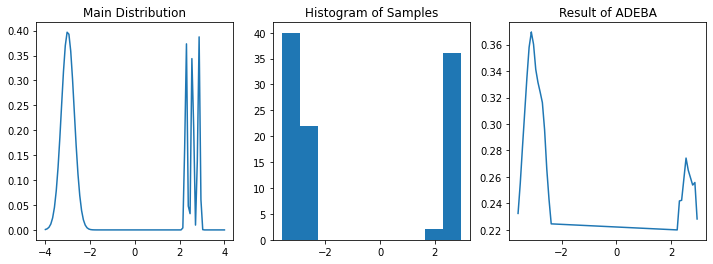

In [ ]:
k = 14
estimate(distributions[k])

## Impact of parameter T

In [ ]:
def estimateT(dist, T):
    s = dist['s']
    w = dist['w']
    x0 = dist['x']
    x = np.linspace(-4, 4, 100)
    y = dist_calc(x, s, w, x0)
    f3_sample = sample_distribution(x, dist_calc, w, s, x0, 100, -4, 4)
    adeba = ADEBA(beta=[0, 1, 0.5], T = T)
    p = adeba.EstimateDensity(f3_sample.reshape(-1, 1))
    return f3_sample, p, x, y

In [ ]:
k = 11
f3_sample_1, p_1, x, y = estimateT(distributions[k], 1)

<ipython-input-13-dbb2e43289b0>:100: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  alpha_max = np.min(alpha[idx_max])
<ipython-input-13-dbb2e43289b0>:101: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  alpha_min = np.min(alpha[idx_min])


In [ ]:
k = 11
f3_sample_5, p_5, x, y = estimateT(distributions[k], 5)

<ipython-input-13-dbb2e43289b0>:100: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  alpha_max = np.min(alpha[idx_max])
<ipython-input-13-dbb2e43289b0>:101: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  alpha_min = np.min(alpha[idx_min])


In [ ]:
k = 11
f3_sample_10, p_10, x, y = estimateT(distributions[k], 10)

<ipython-input-13-dbb2e43289b0>:100: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  alpha_max = np.min(alpha[idx_max])
<ipython-input-13-dbb2e43289b0>:101: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  alpha_min = np.min(alpha[idx_min])


In [ ]:
k = 11
f3_sample, p_20, x, y = estimateT(distributions[k], 20)

<ipython-input-13-dbb2e43289b0>:100: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  alpha_max = np.min(alpha[idx_max])
<ipython-input-13-dbb2e43289b0>:101: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  alpha_min = np.min(alpha[idx_min])


Text(0.5, 1.0, 'Result of ADEBA with T=20')

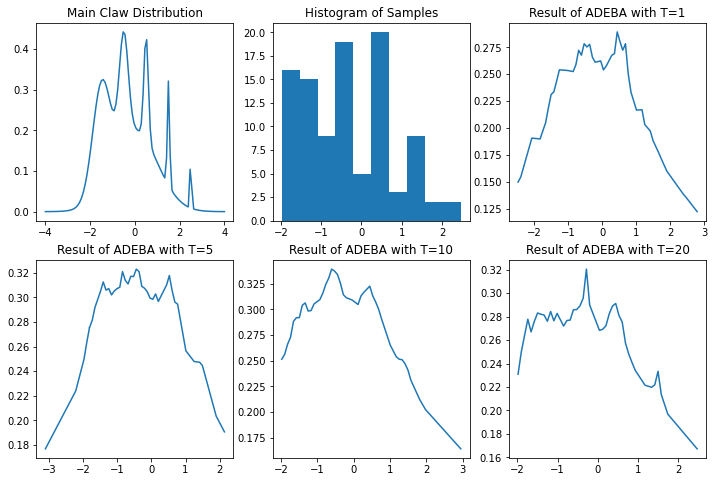

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(12,8))
axs[0,0].plot(x, y)
axs[0,0].set_title('Main Claw Distribution')
axs[0,1].hist(f3_sample)
axs[0,1].set_title('Histogram of Samples')
idx = np.argsort(f3_sample_1)
axs[0,2].plot(f3_sample_1[idx], p_1[idx])
axs[0,2].set_title('Result of ADEBA with T=1')
idx = np.argsort(f3_sample_5)
axs[1,0].plot(f3_sample_5[idx], p_5[idx])
axs[1,0].set_title('Result of ADEBA with T=5')
idx = np.argsort(f3_sample_10)
axs[1,1].plot(f3_sample_10[idx], p_10[idx])
axs[1,1].set_title('Result of ADEBA with T=10')
idx = np.argsort(f3_sample)
axs[1,2].plot(f3_sample[idx], p_20[idx])
axs[1,2].set_title('Result of ADEBA with T=20')

## Impact of parameter B

In [ ]:
def estimateB(dist, B):
    s = dist['s']
    w = dist['w']
    x0 = dist['x']
    x = np.linspace(-4, 4, 100)
    y = dist_calc(x, s, w, x0)
    f3_sample = sample_distribution(x, dist_calc, w, s, x0, 100, -4, 4)
    adeba = ADEBA(beta=B, T = 3)
    p = adeba.EstimateDensity(f3_sample.reshape(-1, 1))
    return f3_sample, p, x, y

In [ ]:
#DEBA
k = 11
f3_sample_zero, p_zero, x, y = estimateB(distributions[k], [0])

<ipython-input-13-dbb2e43289b0>:100: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  alpha_max = np.min(alpha[idx_max])
<ipython-input-13-dbb2e43289b0>:101: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  alpha_min = np.min(alpha[idx_min])


In [ ]:
#BMA_SRL
k = 11
f3_sample_half, p_half, x, y = estimateB(distributions[k], [0.5])

<ipython-input-13-dbb2e43289b0>:100: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  alpha_max = np.min(alpha[idx_max])
<ipython-input-13-dbb2e43289b0>:101: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  alpha_min = np.min(alpha[idx_min])


In [ ]:
#ADEBA-alpha
k = 11
f3_sample_one, p_one, x, y = estimateB(distributions[k], [1])

<ipython-input-13-dbb2e43289b0>:100: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  alpha_max = np.min(alpha[idx_max])
<ipython-input-13-dbb2e43289b0>:101: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  alpha_min = np.min(alpha[idx_min])


In [ ]:
#ADEBA
k = 11
f3_sample_big, p_big, x, y = estimateB(distributions[k], [1.5,2])

<ipython-input-13-dbb2e43289b0>:100: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  alpha_max = np.min(alpha[idx_max])
<ipython-input-13-dbb2e43289b0>:101: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  alpha_min = np.min(alpha[idx_min])


In [ ]:
#ADEBA
k = 11
f3_sample_vary, p_vary, x, y = estimateB(distributions[k], [0,0.5,1,1.5,2])

Text(0.5, 1.0, 'Result of ADEBA with B=[1.5,2]')

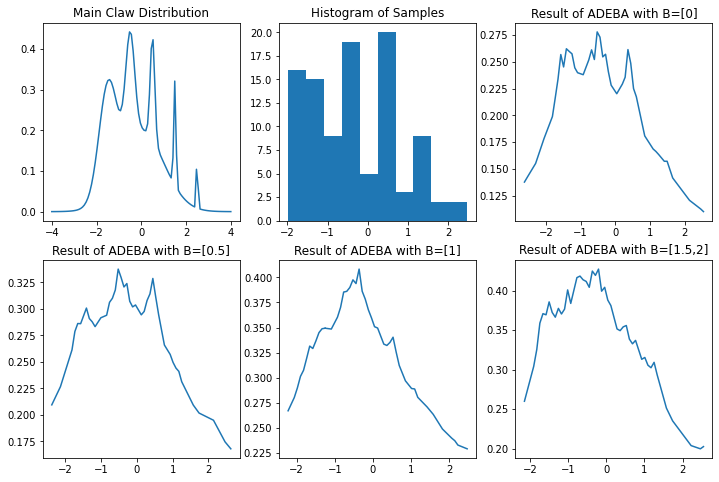

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8))
axs[0,0].plot(x, y)
axs[0,0].set_title('Main Claw Distribution')
axs[0,1].hist(f3_sample)
axs[0,1].set_title('Histogram of Samples')
idx = np.argsort(f3_sample_zero)
axs[0,2].plot(f3_sample_zero[idx], p_zero[idx])
axs[0,2].set_title('Result of ADEBA with B=[0]')
idx = np.argsort(f3_sample_half)
axs[1,0].plot(f3_sample_half[idx], p_half[idx])
axs[1,0].set_title('Result of ADEBA with B=[0.5]')
idx = np.argsort(f3_sample_one)
axs[1,1].plot(f3_sample_one[idx], p_one[idx])
axs[1,1].set_title('Result of ADEBA with B=[1]')
idx = np.argsort(f3_sample_big)
axs[1,2].plot(f3_sample_big[idx], p_big[idx])
axs[1,2].set_title('Result of ADEBA with B=[1.5,2]')

## Impact of # of samples

In [ ]:
def estimateN(dist, N):
    s = dist['s']
    w = dist['w']
    x0 = dist['x']
    x = np.linspace(-4, 4, N)
    y = dist_calc(x, s, w, x0)
    f3_sample = sample_distribution(x, dist_calc, w, s, x0, N, -4, 4)
    adeba = ADEBA(beta=[0, 1, 0.5], T = 3)
    p = adeba.EstimateDensity(f3_sample.reshape(-1, 1))
    return f3_sample, p, x, y

In [ ]:
#DEBA
k = 11
f3_sample_25, p_25, x, y = estimateN(distributions[k], 25)

<ipython-input-13-dbb2e43289b0>:100: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  alpha_max = np.min(alpha[idx_max])
<ipython-input-13-dbb2e43289b0>:101: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  alpha_min = np.min(alpha[idx_min])


In [ ]:
#DEBA
k = 11
f3_sample_50, p_50, x, y = estimateN(distributions[k], 50)

<ipython-input-13-dbb2e43289b0>:100: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  alpha_max = np.min(alpha[idx_max])
<ipython-input-13-dbb2e43289b0>:101: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  alpha_min = np.min(alpha[idx_min])


In [ ]:
#DEBA
k = 11
f3_sample_100, p_100, x, y = estimateN(distributions[k], 100)

<ipython-input-13-dbb2e43289b0>:100: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  alpha_max = np.min(alpha[idx_max])
<ipython-input-13-dbb2e43289b0>:101: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  alpha_min = np.min(alpha[idx_min])


In [ ]:
#DEBA
k = 11
f3_sample_200, p_200, x, y = estimateN(distributions[k], 200)

<ipython-input-13-dbb2e43289b0>:100: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  alpha_max = np.min(alpha[idx_max])
<ipython-input-13-dbb2e43289b0>:101: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  alpha_min = np.min(alpha[idx_min])


Text(0.5, 1.0, 'Result of ADEBA with N=200')

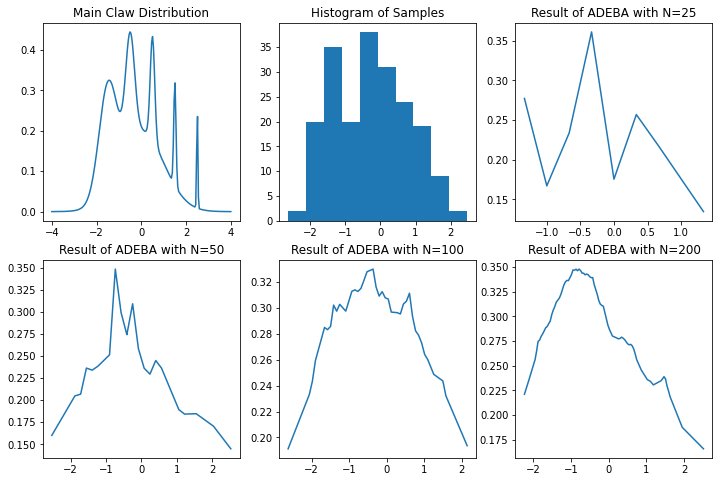

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8))
axs[0,0].plot(x, y)
axs[0,0].set_title('Main Claw Distribution')
axs[0,1].hist(f3_sample)
axs[0,1].set_title('Histogram of Samples')
idx = np.argsort(f3_sample_25)
axs[0,2].plot(f3_sample_25[idx], p_25[idx])
axs[0,2].set_title('Result of ADEBA with N=25')
idx = np.argsort(f3_sample_50)
axs[1,0].plot(f3_sample_50[idx], p_50[idx])
axs[1,0].set_title('Result of ADEBA with N=50')
idx = np.argsort(f3_sample_100)
axs[1,1].plot(f3_sample_100[idx], p_100[idx])
axs[1,1].set_title('Result of ADEBA with N=100')
idx = np.argsort(f3_sample_200)
axs[1,2].plot(f3_sample_200[idx], p_200[idx])
axs[1,2].set_title('Result of ADEBA with N=200')